# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

## Carregamento dos dados do MNIST

In [2]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


<ipython-input-3-6143b94785d1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [4]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

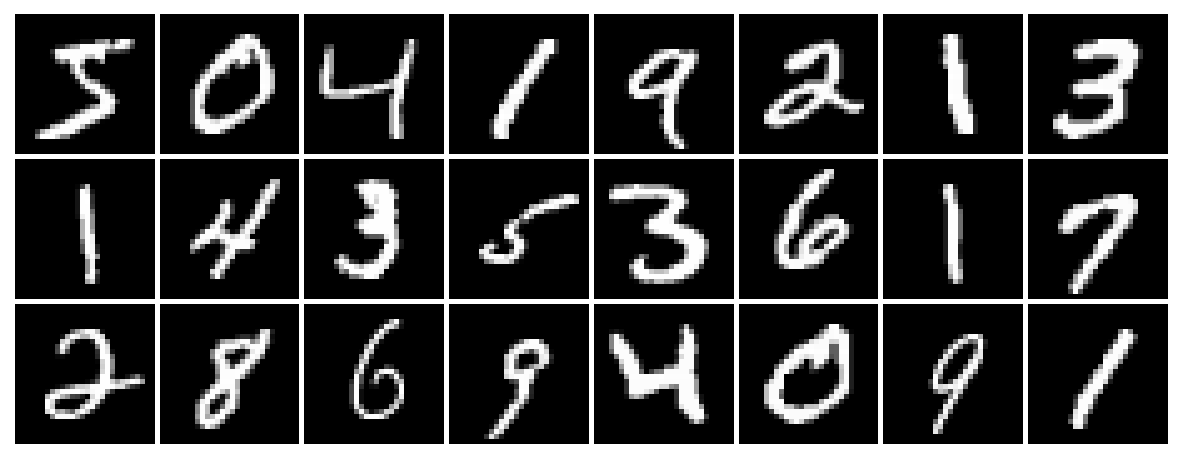

In [5]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


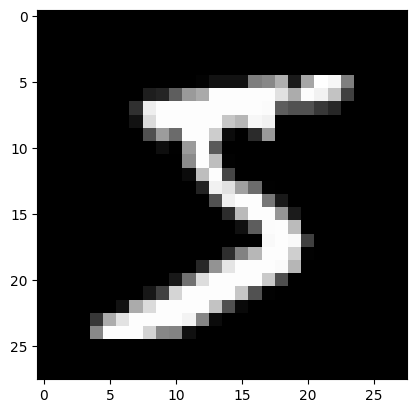

In [6]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [7]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [8]:
## TODO

## Treinamento

### Inicialização dos parâmetros

In [9]:
epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [10]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-f4l00zp9
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-f4l00zp9
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=ad94005c76361332588a363c348cb0cf5ae9a257314e97892c4a6ded6dbdb718
  Stored in directory: /tmp/pip-ephem-wheel-cache-gvlz9cpz/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


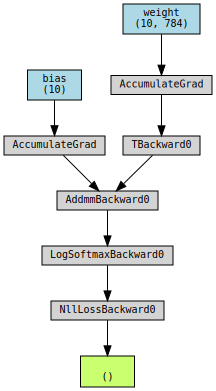

In [11]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [12]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

except KeyboardInterrupt:
    pass

<Figure size 1800x600 with 0 Axes>

In [13]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
print('Final loss:', loss.data)

Final loss: tensor(1.1090)


### Visualizando gráfico de perda durante o treinamento

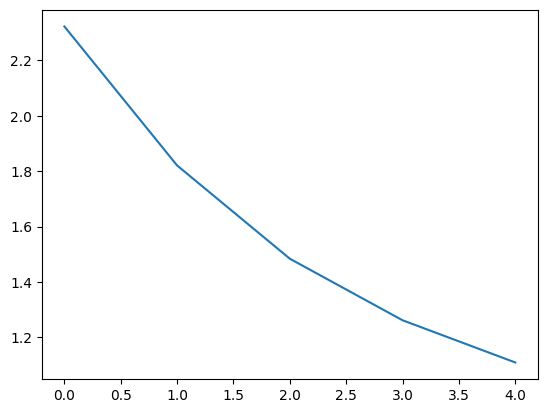

In [15]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [16]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.814


### Matriz de confusão com dados de treinamento e teste

In [17]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,94,0,3,1,1,7,3,2,0,3
1,0,110,13,1,2,3,3,6,6,1
2,1,0,70,1,0,2,0,1,2,0
3,0,1,2,80,1,19,0,0,8,3
4,0,0,2,0,91,6,4,3,0,9
5,0,1,0,2,1,45,2,0,2,1
6,2,1,2,1,2,3,82,0,0,0
7,0,1,5,4,1,1,0,102,0,9
8,0,2,2,2,0,4,0,0,66,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


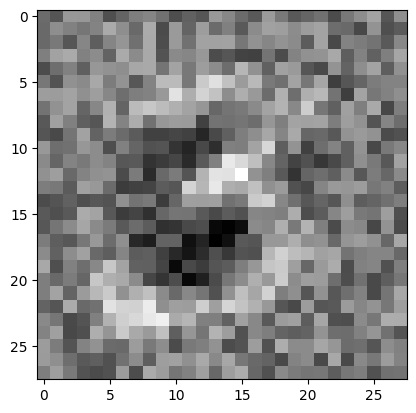

In [18]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

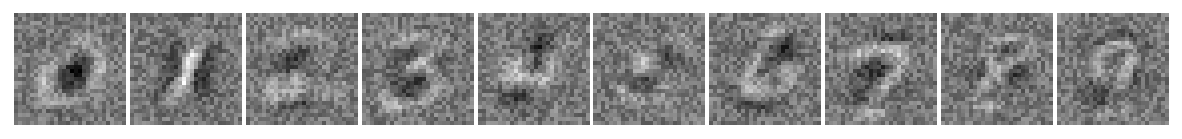

In [19]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [20]:
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        # Exibe o número da época, perda e acurácia
        if (i + 1) % 1 == 0:  # Ajuste aqui se quiser imprimir menos frequentemente
            print(f"Época [{i + 1}/{epochs}], Perda: {loss.item():.4f}, Acurácia: {accuracy * 100:.2f}%")

except KeyboardInterrupt:
    pass

Época [1/5], Perda: 0.9989, Acurácia: 81.40%
Época [2/5], Perda: 0.9169, Acurácia: 83.80%
Época [3/5], Perda: 0.8534, Acurácia: 84.00%
Época [4/5], Perda: 0.8025, Acurácia: 84.90%
Época [5/5], Perda: 0.7606, Acurácia: 85.50%


<Figure size 1800x600 with 0 Axes>

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

In [21]:
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

        # Visualiza gradientes da classe do dígito 4
        if (i + 1) % 1 == 0:  # Ajuste para visualizar em intervalos específicos
            gradientes = outputs.grad  # Obtém gradientes do output
            if gradientes is not None:
                gradiente_digito_4 = gradientes[y_train == 4]
                print(f"Gradientes - Classe 4 (Época {i + 1}): {gradiente_digito_4}")

except KeyboardInterrupt:
    pass

<ipython-input-21-de1c0c78bbd5>:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  gradientes = outputs.grad  # Obtém gradientes do output


<Figure size 1800x600 with 0 Axes>

<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede?  
R- (1, 784)
2. Qual é o shape da saída da rede?  
R- (1, 10)
3. Qual é o número total de parâmetros da rede, incluindo o bias?  
R- 7850

# Aprendizados
